# Machine Learning Mission: Predict Review Star for the Given Yelp Review

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

%matplotlib inline
pd.options.display.mpl_style = 'default'

pd.set_option('display.max_columns', 36)
print pd.__version__

0.19.1


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


First we'll use NLTK to preprocess and tokenize text data

In [2]:
import nltk
import string
from nltk import word_tokenize
from nltk.util import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter


In [3]:
POSITIVE_WORDS = set([line.strip() for line in open('/Users/tony/Documents/positive-words.txt', 'r')])
NEGATIVE_WORDS = set([line.strip() for line in open('/Users/tony/Documents/negative-words.txt', 'r')])
NLTK_STOPWORDS = set(stopwords.words('english'))
MORE_STOPWORDS = set([line.strip() for line in open('/Users/tony/Documents/more_stopwords.txt', 'r')])

def remove_numbers_in_string(s):
    return s.translate(None, string.digits)

def lowercase_remove_punctuation(s):
    s = s.lower()
    s = s.translate(None, string.punctuation)
    return s
    
def remove_stopwords(s):
    token_list = nltk.word_tokenize(s)
    exclude_stopwords = lambda token : token not in NLTK_STOPWORDS
    return ' '.join(filter(exclude_stopwords, token_list))

def filter_out_more_stopwords(token_list):
    return filter(lambda tok : tok not in MORE_STOPWORDS, token_list)

def stem_token_list(token_list):
    STEMMER = PorterStemmer()
    return [STEMMER.stem(tok.decode('utf-8')) for tok in token_list]

def restring_tokens(token_list):
    return ' '.join(token_list)

def lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring(s):
    s = remove_numbers_in_string(s)
    s = lowercase_remove_punctuation(s)
    s = remove_stopwords(s)
    token_list = nltk.word_tokenize(s)
    token_list = filter_out_more_stopwords(token_list)
    token_list = stem_token_list(token_list)
    return restring_tokens(token_list)

Use TURBO dataset from DataWrangling and EDA notebooks

In [4]:
TURBO_DF = pd.read_csv('/Users/tony/Documents/TURBO_p1.csv')
TURBO_DF.head()

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,business_name,neighborhoods,open,business_review_count,business_stars,state,type_x,review_date,review_id,review_stars,review_text,type_y,user_id,review_votes,average_stars,compliments,elite,fans,friends,user_name,user_review_count,type_x.1,user_votes,yelping_since,tip_date,likes,tip_text,type_y.1
0,"{u'Take-out': True, u'Accepts Credit Cards': T...",x1EtuyQAd1NcJ-Esvtop3w,"[Pizza, Restaurants]",Pittsburgh,"2128 Broadway Ave\nBeechview\nPittsburgh, PA 1...","{u'Monday': {u'close': u'22:00', u'open': u'11...",40.404135,-80.030460,SLICE on Broadway,[Beechview],True,77,4.0,PA,business,2015-12-16,9tAMbWawjDh14mhzOii_3Q,4,The pizza is arguably the best in the city. ...,review,qiczib2fO_1VBG8IoCGvVg,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.10,{},[],0,[],Kathy,52,user,"{u'funny': 8, u'useful': 17, u'cool': 5}",2015-11,2015-12-14,0,Friendly staff. Very good pie. Two thumbs up.,tip
1,{},6c2pWWtdQZA3w5raX6k-dg,"[Barbers, Beauty & Spas]",Homestead,"3510 Main St\nHomestead, PA 15120","{u'Tuesday': {u'close': u'17:30', u'open': u'0...",40.385508,-79.903491,Carmine's Barber Shop,[],True,3,3.5,PA,business,2014-04-23,OdwBV3AkP9sm3AxgDmuX2A,5,Great place to get a basic haircut at a fair p...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.17,"{u'note': 1, u'hot': 1}",[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,52,user,"{u'funny': 9, u'useful': 54, u'cool': 11}",2011-11,2014-07-14,0,I've been told that they do open at 4 AM and i...,tip
2,"{u'Alcohol': u'beer_and_wine', u'Noise Level':...",Q4ULAiIE2qCA4RYplCTrUQ,"[Bars, Restaurants, Nightlife, American (New),...",Pittsburgh,"46 18th St\nStrip District\nPittsburgh, PA 15222","{u'Monday': {u'close': u'00:00', u'open': u'11...",40.450714,-79.985514,Primanti Bros.,[Strip District],True,927,3.5,PA,business,2014-03-29,Hemfg9NKZ24bKkGvqnqs5g,4,I love Primantis and this location has some ch...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.17,"{u'note': 1, u'hot': 1}",[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,52,user,"{u'funny': 9, u'useful': 54, u'cool': 11}",2011-11,2015-10-21,0,They take credit cards now!,tip
3,"{u'Take-out': True, u'Accepts Credit Cards': T...",Zg5JB5GBqhmxt9W7tFKN7w,"[American (Traditional), Restaurants]",Pittsburgh,"2302 E Carson St\nSouth Side\nPittsburgh, PA 1...","{u'Monday': {u'close': u'02:00', u'open': u'16...",40.428142,-79.972838,The Library,[South Side],True,153,3.5,PA,business,2015-10-20,920qE9rMfb3awuaOgFBIdA,4,This is definitely one of the better wing join...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 0, u'cool': 0}",3.17,"{u'note': 1, u'hot': 1}",[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,52,user,"{u'funny': 9, u'useful': 54, u'cool': 11}",2011-11,2014-08-11,0,Pretty good AYCE wings special at $12 all day ...,tip
4,"{u'Take-out': True, u'Accepts Credit Cards': T...",jmquanz2qdn_IEgxmn0wsQ,"[Burgers, Restaurants]",Homestead,"299 W Bridge St\nHomestead\nHomestead, PA 15120","{u'Monday': {u'close': u'22:00', u'open': u'11...",40.407153,-79.917764,Burgatory,[Homestead],True,204,4.0,PA,business,2014-04-28,svD5bs2ghmE9wc1aBRONkA,4,Great addition to the Waterfront and at a loca...,review,I_47G-R2_egp7ME5u_ltew,"{u'funny': 0, u'useful': 1, u'cool': 0}",3.17,"{u'note': 1, u'hot': 1}",[],1,"[DsN2dJ6SnTEACr1qC5zpGg, UD7Y1CqfY6mDmRwIuCf6n...",Kevin,52,user,"{u'funny': 9, u'useful': 54, u'cool': 11}",2011-11,2016-01-21,0,The Piggy Butter and Jelly Burger is pretty aw...,tip


In [5]:
for idx in range(5):
    print TURBO_DF.review_text[idx]
    print

The pizza is arguably the best in the city.   Funny thing is, I would have passed this place right by had a friend who lives locally not recommended it.  Oh, and did I mention the Italian hoagie? One word BOMB!   You will not be disappointed eating here.

Great place to get a basic haircut at a fair price! The barbers are like local historians and seem to know something about everybody in town. You might have to wait a bit sometimes to get a haircut, seeing as there is normally only one or two guys working, but the wait normally goes by fast.

I love Primantis and this location has some characters working there. My only problem with this location is that their fries on the sandwiches almost always seem to be undercooked.

This is definitely one of the better wing joints in Pittsburgh and its great that they have a wing night on Sunday (and another wing night on Tuesday!)! Now their wing night is AYCE for $12.50 currently, which is a decent deal, but you'll probably need to put away at 

In [6]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text']
df_with_initial_features_and_preprocessed_review_text = TURBO_DF[initial_features]
%time df_with_initial_features_and_preprocessed_review_text['review_text'] = df_with_initial_features_and_preprocessed_review_text['review_text'].apply(lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)

for idx in range(5):
    print df_with_initial_features_and_preprocessed_review_text.review_text[idx]
    print

CPU times: user 6min 27s, sys: 1.72 s, total: 6min 29s
Wall time: 6min 29s
pizza arguabl citi funni thing pass place friend live local recommend mention italian hoagi word bomb disappoint eat

great place basic haircut fair price barber local historian town wait bit haircut guy work wait fast

love primanti locat charact work problem locat fri sandwich undercook

wing joint pittsburgh great wing night sunday wing night tuesday wing night ayc decent deal youll put make worth compar deal good part ayc delici wing flavor wing minimum flavor order wing front order wing batch blue chees ranch reason cent cool thing wing night wing nake bread dont place option time wing night number flavor sauc recommend hottest flavor dant inferno cajun wet delici arent hot tast great spici bbq buffalo ranch buffalo bleu pretti solid flavor buffalo garlic parmesan nice shred parmesan sprinkl cake wing find fat head recommend thai sauc sweet spici chili thai flavor tast honey bbq expect wing ayc wing night g

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Next, import sklearn functions and partition the data into training and test subsets

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import *
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score

In [8]:
TEST_SIZE = 0.40
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

In [9]:
bag_of_words_vectorizer = CountVectorizer(analyzer = "word",
                                          tokenizer = None,    
                                          preprocessor = None,
                                          ngram_range = (1, 1),
                                          binary = False,
                                          strip_accents='unicode')

binary_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,    
                                    preprocessor = None,
                                    ngram_range = (1, 1),
                                    binary = True,
                                    strip_accents='unicode')

bigram_vectorizer = CountVectorizer(analyzer = "word",
                                    tokenizer = None,
                                    preprocessor = None,
                                    ngram_range = (2, 2),
                                    strip_accents='unicode')

trigram_vectorizer = CountVectorizer(analyzer = "word",
                                     tokenizer = None,
                                     preprocessor = None,
                                     ngram_range = (3, 3),
                                     strip_accents='unicode')

bi_and_trigram_vectorizer = CountVectorizer(analyzer = "word",
                                            tokenizer = None,
                                            preprocessor = None,
                                            ngram_range = (2,3),
                                            strip_accents='unicode')

random_forest_vectorizer = CountVectorizer(analyzer = "word",
                                           tokenizer = None,
                                           preprocessor = None,
                                           ngram_range = (1,1),
                                           strip_accents = 'unicode',
                                           max_features = 1000)

### Bag of Words Model

Transform the Yelp reviews into feature vectors

In [10]:
bow_feature_matrix_train = bag_of_words_vectorizer.fit_transform(train_X)
bow_feature_matrix_test = bag_of_words_vectorizer.transform(test_X)
bow_feature_matrix_train, bow_feature_matrix_test

(<172262x114928 sparse matrix of type '<type 'numpy.int64'>'
 	with 6865532 stored elements in Compressed Sparse Row format>,
 <114842x114928 sparse matrix of type '<type 'numpy.int64'>'
 	with 4518731 stored elements in Compressed Sparse Row format>)

Perform predictions for multinomial NB

In [11]:
multinomial_nb_classifier = MultinomialNB()
multinomial_nb_classifier.fit(bow_feature_matrix_train, train_y)
multinomial_nb_prediction = multinomial_nb_classifier.predict(bow_feature_matrix_test)

Visualize through Confusion Matrix

In [11]:
def make_confusion_matrix_relative(confusion_matrix):
    star_category_classes = [1, 2, 3, 4, 5]
    N = map(lambda clazz : sum(test_y == clazz), star_category_classes)
    relative_confusion_matrix = np.empty((len(star_category_classes), len(star_category_classes)))
    
    for j in range(0, len(star_category_classes)):
        if N[j] > 0:
            relative_frequency = confusion_matrix[j, :] / float(N[j])
            relative_confusion_matrix[j, :] = relative_frequency
            
    return relative_confusion_matrix

def plot_confusion_matrix(confusion_matrix=[[]], title='CM', savefilename=''):
    rcm = make_confusion_matrix_relative(confusion_matrix)
    c = plt.pcolor(rcm, edgecolors='k', linewidths=4, cmap='jet', vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(0.5 + np.arange(5), np.arange(1,6))
    plt.yticks(0.5 + np.arange(5), np.arange(1,6))

    def show_values(pc, fmt="%.2f", **kw):
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if sum(color[:2] > 0.3) >= 2:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)
    
    show_values(c)

    if savefilename:
        plt.savefig(savefilename, bbox_inches='tight')
    
    return plt.show()

[[ 0.67340153  0.04245524  0.10217391  0.08746803  0.09450128]
 [ 0.23388716  0.11886069  0.23169618  0.27515063  0.14040533]
 [ 0.07969309  0.01142209  0.25503531  0.44860058  0.20524893]
 [ 0.02885764  0.00291027  0.04206109  0.51202402  0.41414698]
 [ 0.0249334   0.00109693  0.01077778  0.14655338  0.81663852]]


/usr/local/lib/python2.7/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


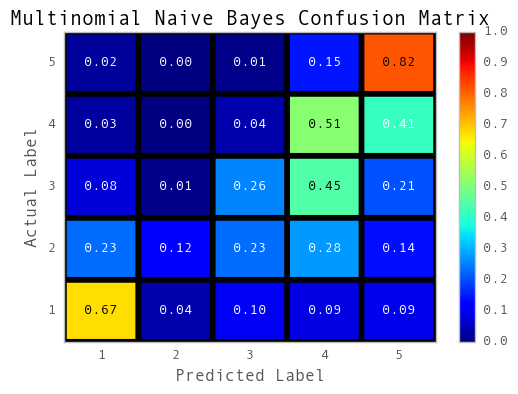

In [13]:
multinomial_confusion_matrix = confusion_matrix(test_y, multinomial_nb_prediction)
print make_confusion_matrix_relative(multinomial_confusion_matrix)
plot_confusion_matrix(multinomial_confusion_matrix, 'Multinomial Naive Bayes Confusion Matrix', savefilename='MultinomialCM.png')

Print classifier performance metrics

In [12]:
def print_classifier_performance_metrics(name, predictions):
    target_names = ['1 star', '2 star', '3 star', '4 star', '5 star']
    
    print "MODEL: %s" % name
    print

    print 'Precision: ' + str(metrics.precision_score(test_y, predictions, average = 'weighted'))
    print 'Recall: ' + str(metrics.recall_score(test_y, predictions, average = 'weighted'))
    print 'F1: ' + str(metrics.f1_score(test_y, predictions, average = 'weighted'))
    print 'Accuracy: ' + str(metrics.accuracy_score(test_y, predictions))

    print
    print 'Classification Report:'
    print classification_report(test_y, predictions, target_names=target_names)
    
    print
    print 'Precision variance: %f' % np.var(precision_score(test_y, predictions, average=None), ddof=len(target_names)-1)
    
    print
    print 'Recall variance: %f' % np.var(recall_score(test_y, predictions, average=None), ddof=len(target_names)-1)

In [15]:
print_classifier_performance_metrics('Multinomial Naive Bayes', multinomial_nb_prediction)

MODEL: Multinomial Naive Bayes

Precision: 0.613900894356
Recall: 0.63093641699
F1: 0.612832564064
Accuracy: 0.63093641699

Classification Report:
             precision    recall  f1-score   support

     1 star       0.54      0.67      0.60      7820
     2 star       0.51      0.12      0.19      5477
     3 star       0.42      0.26      0.32     11469
     4 star       0.51      0.51      0.51     32643
     5 star       0.73      0.82      0.77     57433

avg / total       0.61      0.63      0.61    114842


Precision variance: 0.052085

Recall variance: 0.332670


### Bernoulli Naive Bayes Model

Transform Yelp Reviews into feature vectors by binarizing unigram occurrences

In [29]:
bernoulli_feature_matrix_train = binary_vectorizer.fit_transform(train_X)
bernoulli_feature_matrix_test = binary_vectorizer.transform(test_X)
bernoulli_feature_matrix_train, bernoulli_feature_matrix_test

(<172262x114928 sparse matrix of type '<type 'numpy.int64'>'
 	with 6865532 stored elements in Compressed Sparse Row format>,
 <114842x114928 sparse matrix of type '<type 'numpy.int64'>'
 	with 4518731 stored elements in Compressed Sparse Row format>)

Make predictions with Bernoulli NB

In [30]:
bernoulli_nb_classifier = BernoulliNB().fit(bernoulli_feature_matrix_train, train_y)
bernoulli_nb_prediction = bernoulli_nb_classifier.predict(bernoulli_feature_matrix_test)

Visualize through confusion matrix

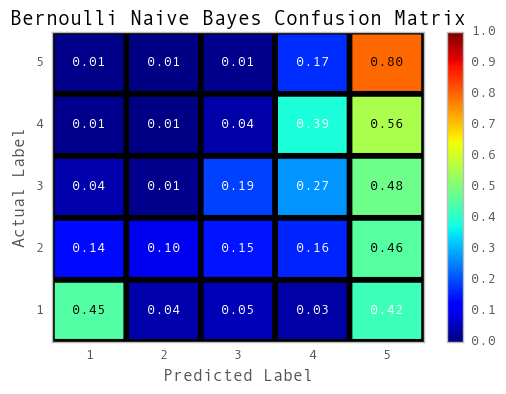

In [31]:
bernoulli_confusion_matrix = confusion_matrix(test_y, bernoulli_nb_prediction)
plot_confusion_matrix(bernoulli_confusion_matrix, 'Bernoulli Naive Bayes Confusion Matrix', savefilename='BernoulliCM.png')

In [32]:
print_classifier_performance_metrics('Bernoulli Naive Bayes', bernoulli_nb_prediction)

MODEL: Bernoulli Naive Bayes

Precision: 0.537633005547
Recall: 0.564183835182
F1: 0.535164340153
Accuracy: 0.564183835182

Classification Report:
             precision    recall  f1-score   support

     1 star       0.61      0.45      0.52      7820
     2 star       0.35      0.10      0.16      5477
     3 star       0.40      0.19      0.26     11469
     4 star       0.47      0.39      0.43     32643
     5 star       0.61      0.80      0.69     57433

avg / total       0.54      0.56      0.54    114842


Precision variance: 0.055217

Recall variance: 0.295530


### Bigram Naive Bayes Model

Transform Yelp reviews into feature vectorizers by counting bigram occurrences

In [25]:
bigram_multinomial_feature_matrix_train = bigram_vectorizer.fit_transform(train_X)
bigram_multinomial_feature_matrix_test = bigram_vectorizer.transform(test_X)
bigram_multinomial_feature_matrix_train, bigram_multinomial_feature_matrix_test

(<172262x2300807 sparse matrix of type '<type 'numpy.int64'>'
 	with 8137912 stored elements in Compressed Sparse Row format>,
 <114842x2300807 sparse matrix of type '<type 'numpy.int64'>'
 	with 4478904 stored elements in Compressed Sparse Row format>)

Make predictions with Bigram Multinomial NB

In [26]:
bigram_multinomial_nb_classifier = MultinomialNB().fit(bigram_multinomial_feature_matrix_train, train_y)
bigram_multinomial_nb_prediction = bigram_multinomial_nb_classifier.predict(bigram_multinomial_feature_matrix_test)

Visualize through confusion matrix

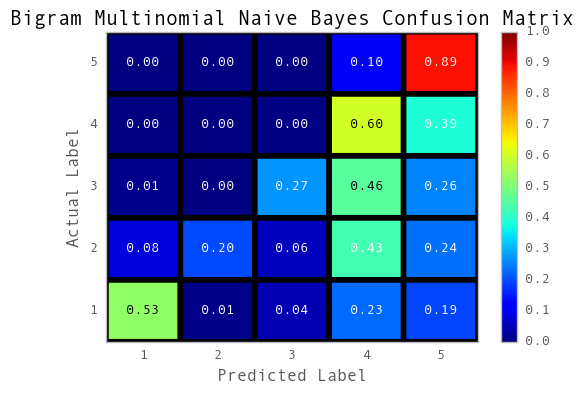

In [27]:
bigram_multinomial_confusion_matrix = confusion_matrix(test_y, bigram_multinomial_nb_prediction)
plot_confusion_matrix(bigram_multinomial_confusion_matrix, 'Bigram Multinomial Naive Bayes Confusion Matrix', savefilename='BigramMultinomialCM.png')

In [28]:
print_classifier_performance_metrics('Bigram Multinomial Naive Bayes', bigram_multinomial_nb_prediction)

MODEL: Bigram Multinomial Naive Bayes

Precision: 0.706160213038
Recall: 0.690749029101
F1: 0.668789615478
Accuracy: 0.690749029101

Classification Report:
             precision    recall  f1-score   support

     1 star       0.83      0.53      0.64      7820
     2 star       0.91      0.20      0.32      5477
     3 star       0.78      0.27      0.40     11469
     4 star       0.56      0.60      0.58     32643
     5 star       0.74      0.89      0.81     57433

avg / total       0.71      0.69      0.67    114842


Precision variance: 0.067246

Recall variance: 0.310338


### Trigram Naive Bayes Model

Transform Yelp reviews into feature vectorizers by counting bigram occurrences

In [37]:
trigram_multinomial_feature_matrix_train = trigram_vectorizer.fit_transform(train_X)
trigram_multinomial_feature_matrix_test = trigram_vectorizer.transform(test_X)
trigram_multinomial_feature_matrix_train, trigram_multinomial_feature_matrix_test

(<172262x5271616 sparse matrix of type '<type 'numpy.int64'>'
 	with 8115835 stored elements in Compressed Sparse Row format>,
 <114842x5271616 sparse matrix of type '<type 'numpy.int64'>'
 	with 2669887 stored elements in Compressed Sparse Row format>)

Make predictions with Trigram Multinomial NB

In [38]:
tri_gram_multinomial_nb_classifier = MultinomialNB().fit(trigram_multinomial_feature_matrix_train, train_y)
tri_gram_multinomial_nb_prediction = tri_gram_multinomial_nb_classifier.predict(trigram_multinomial_feature_matrix_test)

Visualize through confusion matrix

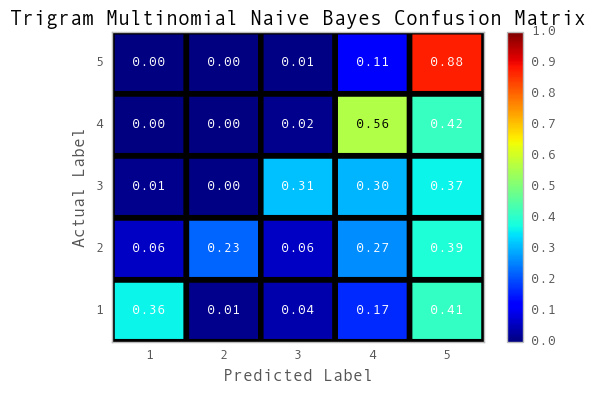

In [39]:
trigram_multinomial_confusion_matrix = confusion_matrix(test_y, tri_gram_multinomial_nb_prediction)
plot_confusion_matrix(trigram_multinomial_confusion_matrix, 'Trigram Multinomial Naive Bayes Confusion Matrix', savefilename='TrigramMultinomialCM.png')

In [40]:
print_classifier_performance_metrics('Trigram Multinomial Naive Bayes', tri_gram_multinomial_nb_prediction)

MODEL: Trigram Multinomial Naive Bayes

Precision: 0.677951637996
Recall: 0.666872746904
F1: 0.644158625762
Accuracy: 0.666872746904

Classification Report:
             precision    recall  f1-score   support

     1 star       0.82      0.36      0.50      7820
     2 star       0.86      0.23      0.36      5477
     3 star       0.71      0.31      0.44     11469
     4 star       0.59      0.56      0.58     32643
     5 star       0.69      0.88      0.77     57433

avg / total       0.68      0.67      0.64    114842


Precision variance: 0.045009

Recall variance: 0.270512


### Random Forest 100 Learners Model

In [41]:
forest100 = RandomForestClassifier(n_estimators = 100, random_state=42)

Transform Yelp reviews into feature vectors

In [42]:
random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_X)

Make predictions with random forest set at 100 learners

In [43]:
%time forest100.fit(random_forest_feature_matrix_train.toarray(), train_y)
forest100_pred = forest100.predict(random_forest_feature_matrix_test.toarray())
np.save('forest100pred', forest100_pred)

CPU times: user 7min 14s, sys: 1.84 s, total: 7min 16s
Wall time: 7min 16s


Visualize results in confusion matrix

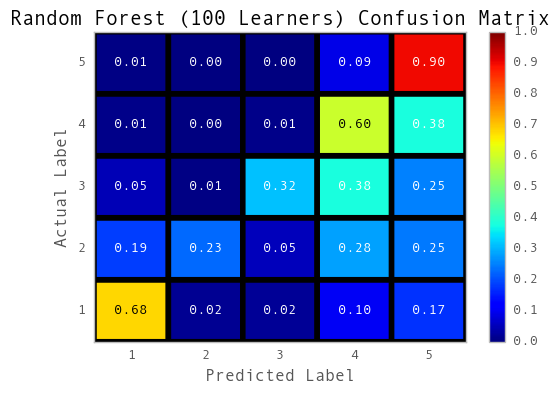

In [44]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest100_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix',
                      savefilename='RandomForestCM.png')

In [45]:
print_classifier_performance_metrics('Random Forest (100 Learners)', forest100_pred)

MODEL: Random Forest (100 Learners)

Precision: 0.71215878453
Recall: 0.707737587294
F1: 0.687903374307
Accuracy: 0.707737587294

Classification Report:
             precision    recall  f1-score   support

     1 star       0.70      0.68      0.69      7820
     2 star       0.81      0.23      0.36      5477
     3 star       0.80      0.32      0.45     11469
     4 star       0.62      0.60      0.61     32643
     5 star       0.74      0.90      0.81     57433

avg / total       0.71      0.71      0.69    114842


Precision variance: 0.024132

Recall variance: 0.299555


### SVC Model

Initialize feature vector and SVC model

In [46]:
svc_feature_matrix_train = random_forest_feature_matrix_train
svc_feature_matrix_test = random_forest_feature_matrix_test

svc = SVC()

Train SVC model

In [ ]:
%time svc.fit(svc_feature_matrix_train, train_y) 

In [ ]:
%time svc_predictions = svc.predict(svc_feature_matrix_test)
np.save('svcPred', svc_predictions)

In [33]:
if os.path.isfile('svcPred.npy'):
    svc_predictions = np.load('svcPred.npy')

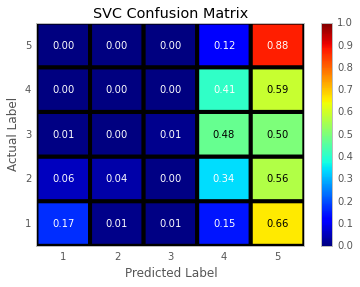

In [35]:
svc_confusion_matrix = confusion_matrix(test_y, svc_predictions)
plot_confusion_matrix(svc_confusion_matrix, 'SVC Confusion Matrix', savefilename='SVC_CM.png')

In [36]:
print_classifier_performance_metrics('SVC', svc_predictions)

MODEL: SVC

Precision: 0.538277121141
Recall: 0.517447386286
F1: 0.446632174967
Accuracy: 0.517447386286

Classification Report:
             precision    recall  f1-score   support

     1 star       0.67      0.17      0.27       884
     2 star       0.69      0.04      0.07       810
     3 star       0.58      0.01      0.03      1965
     4 star       0.49      0.41      0.44      4897
     5 star       0.52      0.88      0.66      6174

avg / total       0.54      0.52      0.45     14730


Precision variance: 0.030706

Recall variance: 0.513996


### Bigram-Trigram Model

Transform Yelp reviews into feature vectors

In [10]:
bi_and_trigram_multinomial_feature_matrix_train = bi_and_trigram_vectorizer.fit_transform(train_X)
bi_and_trigram_multinomial_feature_matrix_test = bi_and_trigram_vectorizer.transform(test_X)
bi_and_trigram_multinomial_feature_matrix_train, bi_and_trigram_multinomial_feature_matrix_test

(<172262x7572423 sparse matrix of type '<type 'numpy.int64'>'
 	with 16253747 stored elements in Compressed Sparse Row format>,
 <114842x7572423 sparse matrix of type '<type 'numpy.int64'>'
 	with 7148791 stored elements in Compressed Sparse Row format>)

Make predictions with Bi-Trigram Multinomial NB

In [11]:
bi_and_tri_gram_multinomial_nb_classifier = MultinomialNB().fit(bi_and_trigram_multinomial_feature_matrix_train, train_y)
bi_and_tri_gram_multinomial_nb_prediction = bi_and_tri_gram_multinomial_nb_classifier.predict(bi_and_trigram_multinomial_feature_matrix_test)

Visualize results in confusion matrix

/usr/local/lib/python2.7/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


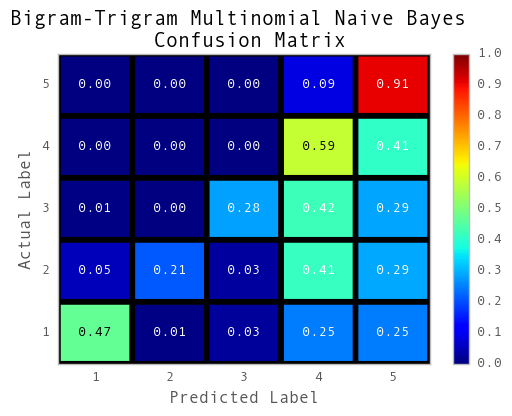

In [16]:
bi_and_tri_gram_multinomial_confusion_matrix = confusion_matrix(test_y, bi_and_tri_gram_multinomial_nb_prediction)
plot_confusion_matrix(bi_and_tri_gram_multinomial_confusion_matrix,
                      'Bigram-Trigram Multinomial Naive Bayes \n Confusion Matrix', savefilename='BiAndTrigramMultinomialCM.png')

In [21]:
print_classifier_performance_metrics('Bi-and-Trigram Multinomial Naive Bayes', bi_and_tri_gram_multinomial_nb_prediction)

MODEL: Bi-and-Trigram Multinomial Naive Bayes

Precision: 0.716881319765
Recall: 0.692168370457
F1: 0.668495407402
Accuracy: 0.692168370457

Classification Report:
             precision    recall  f1-score   support

     1 star       0.88      0.47      0.61      7820
     2 star       0.95      0.21      0.35      5477
     3 star       0.87      0.28      0.43     11469
     4 star       0.58      0.59      0.58     32643
     5 star       0.72      0.91      0.80     57433

avg / total       0.72      0.69      0.67    114842


Precision variance: 0.091426

Recall variance: 0.306446


In [16]:
from operator import itemgetter

def argmax(dictionary):
    return (max(dictionary.iteritems(), key=itemgetter(1)))[0]

class Multinomial_NB_Classifier():
    
    def train(self, class_labels, documents, class_priors=[], complement=False):       
        Classes = sorted(list(set(class_labels)))
        Vocabulary = reduce(lambda V, d : V.union(set(d.split())), documents, set())
        
        if len(class_priors) != len(Classes):
            N_documents_per_class = lambda c : sum(c == np.array(class_labels))
            N_documents = len(documents)
            class_priors = {c : N_documents_per_class(c) / float(N_documents) for c in Classes}
        
        Text_given_class = {c : documents[c == np.array(class_labels)].sum() for c in Classes}
        length_of_concatenated_documents_of_class = {c : len(Text_given_class[c].split()) for c in Classes}
        total_length_of_concatenated_documents_of_all_classes = sum([length_of_concatenated_documents_of_class[C] for C in Classes])
        
        absolute_frequency_vectorizer = CountVectorizer(analyzer = "word",
                                                        vocabulary = Vocabulary,
                                                        ngram_range = (1, 1),
                                                        binary = False)
        documentclass_termunigram_matrix = absolute_frequency_vectorizer.fit_transform(Text_given_class.values())
    
        number_of_feature_words = documentclass_termunigram_matrix.shape[1]
        feature_word_index = dict(zip(absolute_frequency_vectorizer.get_feature_names(), range(number_of_feature_words)))
        word_counts_irregardless_of_class = documentclass_termunigram_matrix.sum(axis=0)
        
        WORD_GIVEN_CLASS_CPT = {}
        COMPLEMENT_WORD_GIVEN_CLASS_CPT = {}
        K = len(Vocabulary)
        
        for class_idx, c in enumerate(Classes):
            if c not in WORD_GIVEN_CLASS_CPT:
                WORD_GIVEN_CLASS_CPT[c] = {}
                COMPLEMENT_WORD_GIVEN_CLASS_CPT[c] = {}

            for w in Vocabulary:
                T_wc = documentclass_termunigram_matrix[class_idx, feature_word_index[w]]
                WORD_GIVEN_CLASS_CPT[c][w] = float(1 + T_wc) / (K + length_of_concatenated_documents_of_class[c])
                
                C_wc = word_counts_irregardless_of_class[0, feature_word_index[w]] - T_wc
                complement_classes_wc = total_length_of_concatenated_documents_of_all_classes-length_of_concatenated_documents_of_class[c]
                COMPLEMENT_WORD_GIVEN_CLASS_CPT[c][w] = float(1 + C_wc) / (K + complement_classes_wc)
           
        self.classes = Classes
        self.vocabulary = Vocabulary
        self.class_priors = class_priors
        self.words_cpt = WORD_GIVEN_CLASS_CPT
        
        if complement:
            self.complement = True
            self.complement_cpt = COMPLEMENT_WORD_GIVEN_CLASS_CPT
        else:
            self.complement = False
            
        return self

    def predict(self, documents):
        target_labels = []
        
        for d in documents:
            score = {}
            Words_d = set(d.split())
            
            for class_idx, c in enumerate(self.classes):
                word_log_likelihoods = np.log([self.words_cpt[c][w] for w in Words_d if w in self.vocabulary])
                score[c] = np.log(self.class_priors[c])
                
                if self.complement:
                    word_in_complement_classes_log_likelihoods = np.log([self.complement_cpt[c][w] for w in Words_d if w in self.vocabulary])
                    score[c] -= sum(word_in_complement_classes_log_likelihoods)
                else:
                    score[c] += sum(word_log_likelihoods)
                    
            c_map = argmax(score)
            target_labels.append(c_map)
            
        return target_labels                            

In [17]:
%time clf = Multinomial_NB_Classifier().train(class_labels=train_y, documents=train_X, complement=True)

CPU times: user 21min 24s, sys: 9min 52s, total: 31min 16s
Wall time: 31min 20s


In [18]:
%time pre = clf.predict(test_X)

CPU times: user 32.5 s, sys: 333 ms, total: 32.9 s
Wall time: 32.8 s


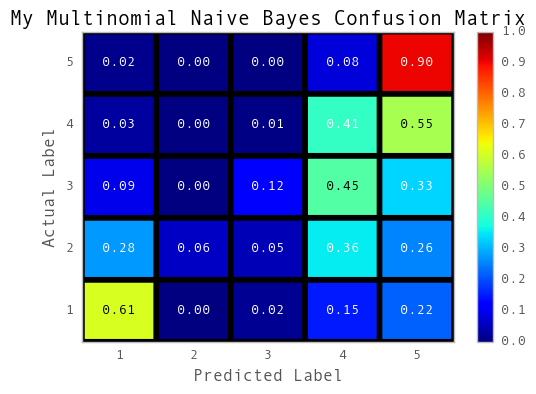

In [19]:
my_multinomial_confusion_matrix = confusion_matrix(test_y, pre)
plot_confusion_matrix(my_multinomial_confusion_matrix,
                      'My Multinomial Naive Bayes Confusion Matrix', savefilename='MyMultinomialCM.png')

In [20]:
print_classifier_performance_metrics('My Multinomial Naive Bayes', pre)

MODEL: My Multinomial Naive Bayes

Precision: 0.627578336106
Recall: 0.624475366155
F1: 0.579066423155
Accuracy: 0.624475366155

Classification Report:
             precision    recall  f1-score   support

     1 star       0.52      0.61      0.56      7820
     2 star       0.92      0.06      0.11      5477
     3 star       0.67      0.12      0.20     11469
     4 star       0.51      0.41      0.45     32643
     5 star       0.67      0.90      0.77     57433

avg / total       0.63      0.62      0.58    114842


Precision variance: 0.112168

Recall variance: 0.488301


### Top 10 Features for each Star Category of Bag of Words Multinomial NB

In [21]:
N = 10
vocab = np.array([t for t, i in sorted(bag_of_words_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

for i, label in enumerate(sorted(set(train_y))):
 top_n_features_indices = np.argsort(multinomial_nb_classifier.coef_[i])[-N:]
 print "\nThe top %d most informative features for star category %d: \n%s" % (N, label, ", ".join(vocab[top_n_features_indices]))


The top 10 most informative features for star category 1: 
custom, good, wait, dont, back, order, servic, food, place, time

The top 10 most informative features for star category 2: 
didnt, wait, dont, back, servic, order, good, time, place, food

The top 10 most informative features for star category 3: 
im, back, dont, great, servic, order, time, place, food, good

The top 10 most informative features for star category 4: 
back, nice, servic, love, order, time, great, food, place, good

The top 10 most informative features for star category 5: 
make, back, order, servic, time, love, good, food, great, place


### Top 10 Features for each Star Category of Bigram Multinomial NB

In [24]:
import sklearn
print sklearn.__version__

0.18.1


In [29]:
N = 10
vocab = np.array([t for t, i in sorted(bigram_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])

for i, label in enumerate(sorted(set(train_y))):
 top_n_features_indices = np.argsort(bigram_multinomial_nb_classifier.coef_[i])[-N:]
 print "\nThe top %d most informative features for star category %d: \n%s" % (N, label, ", ".join(vocab[top_n_features_indices]))


The top 10 most informative features for star category 1: 
call back, dont care, come back, wont back, la vega, give star, wast time, front desk, wait minut, custom servic

The top 10 most informative features for star category 2: 
give star, come back, good food, ice cream, wont back, happi hour, wait minut, pretti good, food good, custom servic

The top 10 most informative features for star category 3: 
staff friendli, servic good, give star, good food, ice cream, la vega, custom servic, food good, happi hour, pretti good

The top 10 most informative features for star category 4: 
love place, great food, staff friendli, good food, ice cream, food good, great place, pretti good, la vega, happi hour

The top 10 most informative features for star category 5: 
food great, ice cream, custom servic, great place, happi hour, great servic, la vega, great food, highli recommend, love place


### ReFeature Engineering to Improve Classifier Accuracy

In [30]:
import json
from collections import OrderedDict
 
def convert_json_dict_string_to_python_dict(json_string_dict):
    return json.loads(json_string_dict.replace('\'', '"').replace('u"', '"'))

def get_number_of_review_votes_that_are(cool_or_funny_or_useful):
    assert cool_or_funny_or_useful in ['cool', 'funny', 'useful']
    return lambda review_votes_dict : review_votes_dict[cool_or_funny_or_useful]

def get_total_review_votes(review_votes_dict):
    return review_votes_dict['cool'] + review_votes_dict['funny'] + review_votes_dict['useful']

def get_number_of_compliments_that_are(cool_or_cute_or_funny_or_hot_or_list_or_more_or_note_or_photos_or_plain_or_profile_or_writer):
    key = cool_or_cute_or_funny_or_hot_or_list_or_more_or_note_or_photos_or_plain_or_profile_or_writer
    assert cool_or_cute_or_funny_or_hot_or_list_or_more_or_note_or_photos_or_plain_or_profile_or_writer in [u'cool',
                                                                                                            u'cute',
                                                                                                            u'funny',
                                                                                                            u'hot',
                                                                                                            u'list',
                                                                                                            u'more',
                                                                                                            u'note',
                                                                                                            u'photos',
                                                                                                            u'plain',
                                                                                                            u'profile',
                                                                                                            u'writer']
    return lambda compliments_dict : compliments_dict[key] if key in compliments_dict else 0

def count_number_of_positive_words(document):
    return len(filter(lambda tok : tok in POSITIVE_WORDS, document.split()))

def count_number_of_negative_words(document):
    return len(filter(lambda tok : tok in NEGATIVE_WORDS, document.split()))

def check_that_userid_does_not_appear_in_its_friendid_list(df):
    for i, x in df.iterrows():
        d = OrderedDict(x)
        assert d['business_id'] not in d['friends_id_list']

def get_average_friends_average_stars(df):
    
    def apply_func(friend_user_id_list):
        friend_ids_that_exist_in_df = set(df['user_id']).intersection(set(friend_user_id_list))
        indices_of_records_with_friend_ids = df['user_id'].isin(friend_ids_that_exist_in_df)
        userid_and_averagestars_df = df[['user_id', 'user_average_stars']]
        friends_average_stars_indexed_by_userid_df = userid_and_averagestars_df.loc[indices_of_records_with_friend_ids].groupby('user_id').mean()
        return np.mean(friends_average_stars_indexed_by_userid_df['user_average_stars'])
    
    return apply_func

In [32]:
df_with_refeature_engineered = df_with_initial_features_and_preprocessed_review_text
df_with_refeature_engineered['review_votes'] = TURBO_DF.review_votes.apply(convert_json_dict_string_to_python_dict)
df_with_refeature_engineered['review_cool'] = df_with_refeature_engineered.review_votes.apply(get_number_of_review_votes_that_are('cool'))
df_with_refeature_engineered['review_funny'] = df_with_refeature_engineered.review_votes.apply(get_number_of_review_votes_that_are('funny'))
df_with_refeature_engineered['review_useful'] = df_with_refeature_engineered.review_votes.apply(get_number_of_review_votes_that_are('useful'))
df_with_refeature_engineered['review_votes_count'] = df_with_refeature_engineered.review_votes.apply(get_total_review_votes)
df_with_refeature_engineered['review_length'] = df_with_refeature_engineered.review_text.apply(len)

df_with_refeature_engineered['user_id'] = TURBO_DF.user_id
df_with_refeature_engineered['user_votes'] = TURBO_DF.user_votes.apply(convert_json_dict_string_to_python_dict)
df_with_refeature_engineered['user_cool'] = df_with_refeature_engineered.user_votes.apply(get_number_of_review_votes_that_are('cool'))
df_with_refeature_engineered['user_funny'] = df_with_refeature_engineered.user_votes.apply(get_number_of_review_votes_that_are('funny'))
df_with_refeature_engineered['user_useful'] = df_with_refeature_engineered.user_votes.apply(get_number_of_review_votes_that_are('useful'))
df_with_refeature_engineered['user_votes_count'] = df_with_refeature_engineered.user_votes.apply(get_total_review_votes)
df_with_refeature_engineered['user_review_count'] = TURBO_DF.user_review_count
df_with_refeature_engineered['user_fans'] = TURBO_DF.fans
df_with_refeature_engineered['user_friends_count'] = TURBO_DF.friends.apply(len)
df_with_refeature_engineered['user_years_elite_count'] = TURBO_DF.elite.apply(len)
df_with_refeature_engineered['user_compliments'] = TURBO_DF.compliments.apply(convert_json_dict_string_to_python_dict)
df_with_refeature_engineered['user_compliments_cool'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('cool'))
df_with_refeature_engineered['user_compliments_cute'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('cute'))
df_with_refeature_engineered['user_compliments_funny'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('funny'))
df_with_refeature_engineered['user_compliments_hot'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('hot'))
df_with_refeature_engineered['user_compliments_list'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('list'))
df_with_refeature_engineered['user_compliments_more'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('more'))
df_with_refeature_engineered['user_compliments_note'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('note'))
df_with_refeature_engineered['user_compliments_photos'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('photos'))
df_with_refeature_engineered['user_compliments_plain'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('plain'))
df_with_refeature_engineered['user_compliments_profile'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('profile'))
df_with_refeature_engineered['user_compliments_writer'] = df_with_refeature_engineered.user_compliments.apply(get_number_of_compliments_that_are('writer'))

df_with_refeature_engineered['user_average_stars'] = TURBO_DF.average_stars
df_with_refeature_engineered['business_stars'] = TURBO_DF.business_stars

df_with_refeature_engineered['positive_words_count'] = TURBO_DF.review_text.apply(count_number_of_positive_words)
df_with_refeature_engineered['negative_words_count'] = TURBO_DF.review_text.apply(count_number_of_negative_words)
df_with_refeature_engineered['neutral_words_count'] = df_with_refeature_engineered.review_length - (df_with_refeature_engineered.positive_words_count + df_with_refeature_engineered.negative_words_count)
df_with_refeature_engineered['positive_words_count_over_review_length'] = df_with_refeature_engineered.positive_words_count / (1.0*df_with_refeature_engineered.review_length)
df_with_refeature_engineered['negative_words_count_over_review_length'] = df_with_refeature_engineered.negative_words_count / (1.0*df_with_refeature_engineered.review_length)
df_with_refeature_engineered['neutral_words_count_over_review_length'] = df_with_refeature_engineered.neutral_words_count / (1.0*df_with_refeature_engineered.review_length)
df_with_refeature_engineered['positive_to_negative_words_count_ratio'] = df_with_refeature_engineered.positive_words_count / (1.0*df_with_refeature_engineered.negative_words_count)
df_with_refeature_engineered['negative_to_positive_words_count_ratio'] = df_with_refeature_engineered.negative_words_count / (1.0*df_with_refeature_engineered.positive_words_count)

df_with_refeature_engineered['friends_id_list'] = TURBO_DF.friends.apply(lambda s : s.replace('[', '').replace(']','').split(', '))
check_that_userid_does_not_appear_in_its_friendid_list(df_with_refeature_engineered)
df_with_refeature_engineered['friends_average_stars'] = df_with_refeature_engineered.friends_id_list.apply(get_average_friends_average_stars(df_with_refeature_engineered))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [365]:
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

def triangularize_symmetric_matrix(x, y, z):
    x_new = x[0:-1]
    y_new = y[-1:0:-1]
    tmp = np.empty(z.shape)
    tmp.fill(np.nan)
    for i in range(len(z)):
        tmp[i, 0 :i] = z[i, 0:i]
    tmp = np.flipud(tmp)
    z_new = tmp
    return (x_new, y_new, z_new)

In [384]:
factors_affecting_review_stars_sorted_by_corr = sorted(zip(Corr_df.index, Corr_df['review_stars']), key = lambda factor_corr_pair : np.abs(factor_corr_pair[1]), reverse=True)
series_of_factors_affecting_review_stars_sorted_by_corr = Series(OrderedDict(factors_affecting_review_stars_sorted_by_corr))
series_of_factors_affecting_review_stars_sorted_by_corr

review_stars                               1.000000
business_stars                             0.441851
user_average_stars                         0.439100
negative_to_positive_words_count_ratio    -0.349883
positive_to_negative_words_count_ratio     0.276092
negative_words_count                      -0.248268
negative_words_count_over_review_length   -0.243917
positive_words_count_over_review_length    0.206898
neutral_words_count_over_review_length    -0.081850
positive_words_count                       0.080719
neutral_words_count                       -0.065216
review_length                             -0.064584
friends_average_stars                      0.052303
review_cool                                0.046922
user_review_count                         -0.036686
user_compliments_more                     -0.029204
user_compliments_funny                    -0.027014
user_compliments_writer                   -0.026673
user_compliments_note                     -0.025679
user_complim

So positive and negative words per review length and ratio turn out to have a good correlation of review stars

In [372]:
df_with_refeature_engineered.positive_words_count_over_review_length.describe()

count    36802.000000
mean         0.018872
std          0.014927
min          0.000000
25%          0.010204
50%          0.016760
75%          0.024691
max          0.250000
Name: positive_words_count_over_review_length, dtype: float64

In [345]:
df_with_refeature_engineered['negative_words_count_over_review_length'].describe()

count    36802.000000
mean         0.005040
std          0.007362
min          0.000000
25%          0.000000
50%          0.003003
75%          0.007673
max          0.333333
Name: negative_words_count_over_review_length, dtype: float64

Let's overplay the negativity of Yelp reviews since our classifier often confuses 1,2,3 star reviews with 4 stars

In [189]:
def multiply_negative_words(by=1):
    def apply_func(document=''):
        negative_words = filter(lambda s : s in NEGATIVE_WORDS, document.split())
        return document + ' ' + ' '.join(negative_words * (by-1))
    return apply_func

In [190]:
negativity_factor = 10
m  = multiply_negative_words(negativity_factor)
df_with_refeature_engineered_and_preprocessed_review_text = TURBO_DF[initial_features]
df_with_refeature_engineered_and_preprocessed_review_text['overly_negative_review_text'] = TURBO_DF.review_text.apply(m)
%time df_with_refeature_engineered_and_preprocessed_review_text.overly_negative_review_text = df_with_refeature_engineered_and_preprocessed_review_text.overly_negative_review_text.apply(lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)

for idx in range(5):
    print df_with_refeature_engineered_and_preprocessed_review_text.overly_negative_review_text[idx]
    print

-c:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/kevin/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


CPU times: user 1min 41s, sys: 228 ms, total: 1min 41s
Wall time: 1min 41s
awesom decor great servic hidden gem scottsdal delici uniqu menu lamb fondu great trout salad chicken interest bread basket assort muffin bread divers dessert menu bit chocol great place restaur scottsdal

defalco locat thoma eaten italian deli valley place rival qualiti food excel staff custom continu return highli recommend purista chp chees steak margerit pizza tim special pizza soup italian item beat wine select fantast toni defalco owner singl wine put bottl shelv fantast wine number region place eat time week year healthi delici make call order ahead place busi defalco true desert classic year recip friendliest staff dedic excel desert desert desert desert desert desert desert desert desert

defalco locat thoma eaten italian deli valley place rival qualiti food excel staff custom continu return highli recommend purista chp chees steak margerit pizza tim special pizza soup italian item beat wine select fant

### Random Forest on 20% Training Data

In [13]:
TEST_SIZE = 0.20
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

In [14]:
forest100 = RandomForestClassifier(n_estimators = 100)

Transform Yelp Reviews into feature vectors

In [15]:
random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_X)

Make predictions

In [16]:
%time forest100.fit(random_forest_feature_matrix_train.toarray(), train_y)
forest100_pred = forest100.predict(random_forest_feature_matrix_test.toarray())

CPU times: user 11min 3s, sys: 4.3 s, total: 11min 8s
Wall time: 11min 10s


Visualize results in confusion matrix

/usr/local/lib/python2.7/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


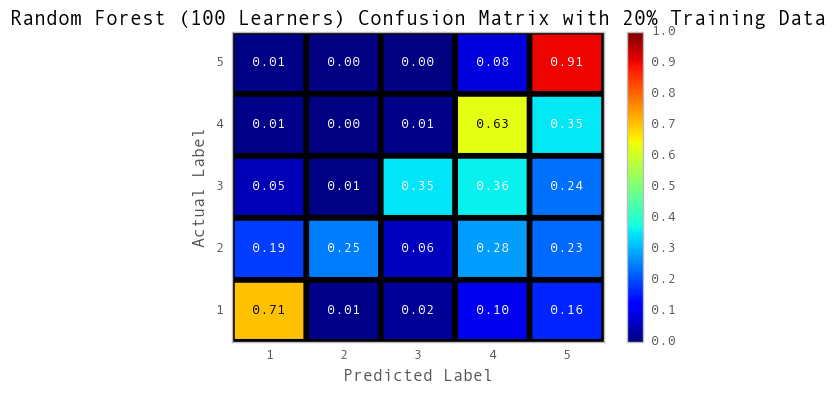

In [17]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest100_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix with 20% Training Data',
                      savefilename='TwentyRandomForestCM.png')

In [18]:
print_classifier_performance_metrics('Random Forest (100 Learners) with 20% Training Data', forest100_pred)

MODEL: Random Forest (100 Learners) with 20% Training Data

Precision: 0.731772391822
Recall: 0.725832012678
F1: 0.708075136075
Accuracy: 0.725832012678

Classification Report:
             precision    recall  f1-score   support

     1 star       0.70      0.71      0.70      3869
     2 star       0.85      0.25      0.38      2777
     3 star       0.82      0.35      0.49      5712
     4 star       0.64      0.63      0.63     16248
     5 star       0.76      0.91      0.82     28815

avg / total       0.73      0.73      0.71     57421


Precision variance: 0.029291

Recall variance: 0.286069


In [19]:
TEST_SIZE = 0.20
train_X, test_X, train_y, test_y = train_test_split(df_with_initial_features_and_preprocessed_review_text.review_text,
                                                    df_with_initial_features_and_preprocessed_review_text.review_stars,
                                                    test_size=TEST_SIZE,
                                                    random_state=42)

ONE_STAR_LABEL = 1
TWO_STAR_LABEL = 2
THREE_STAR_LABEL = 3
FOUR_STAR_LABEL = 4

one_star_reviews = train_X[train_y == ONE_STAR_LABEL]
two_star_reviews = train_X[train_y == TWO_STAR_LABEL]
three_star_reviews = train_X[train_y == THREE_STAR_LABEL]
four_star_reviews = train_X[train_y == FOUR_STAR_LABEL]

one_star_labels = train_y[train_y == ONE_STAR_LABEL]
two_star_labels = train_y[train_y == TWO_STAR_LABEL]
three_star_labels = train_y[train_y == THREE_STAR_LABEL]

difference_btw_number_of_4_and_1_stars = len(four_star_reviews) - len(one_star_reviews)
difference_btw_number_of_4_and_2_stars = len(four_star_reviews) - len(two_star_reviews)
difference_btw_number_of_4_and_3_stars = len(four_star_reviews) - len(three_star_reviews)

assert (np.array([difference_btw_number_of_4_and_1_stars,
                 difference_btw_number_of_4_and_2_stars,
                 difference_btw_number_of_4_and_3_stars]) > 0).all()

q1 = difference_btw_number_of_4_and_1_stars/len(one_star_reviews)
r1 = difference_btw_number_of_4_and_1_stars - len(one_star_reviews) * q1
q2 = difference_btw_number_of_4_and_2_stars/len(two_star_reviews)
r2 = difference_btw_number_of_4_and_2_stars - len(two_star_reviews) * q2
q3 = difference_btw_number_of_4_and_3_stars/len(three_star_reviews)
r3 = difference_btw_number_of_4_and_3_stars - len(three_star_reviews) * q3

train_X = np.vstack([np.reshape(train_X, (len(train_X), 1)),
                     np.tile(one_star_reviews, (1, q1)).T,
                     np.reshape(one_star_reviews[:r1], (r1, 1)),
                     np.tile(two_star_reviews, (1, q2)).T,
                     np.reshape(two_star_reviews[:r2], (r2, 1)),
                     np.tile(three_star_reviews, (1, q3)).T,
                     np.reshape(three_star_reviews[:r3], (r3, 1))])[:,0]

train_y = np.vstack([np.reshape(train_y, (len(train_y), 1)),
                     np.tile(one_star_labels, (1, q1)).T,
                     np.reshape(one_star_labels[:r1], (r1, 1)),
                     np.tile(two_star_labels, (1, q2)).T,
                     np.reshape(two_star_labels[:r2], (r2, 1)),
                     np.tile(three_star_labels, (1, q3)).T,
                     np.reshape(three_star_labels[:r3], (r3, 1))])[:,0]

/usr/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:224: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return reshape(newshape, order=order)


In [20]:
random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_X)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_X)

In [21]:
%time forest100.fit(random_forest_feature_matrix_train.toarray(), train_y)
forest100_pred = forest100.predict(random_forest_feature_matrix_test.toarray())

CPU times: user 17min 48s, sys: 5.95 s, total: 17min 54s
Wall time: 17min 57s


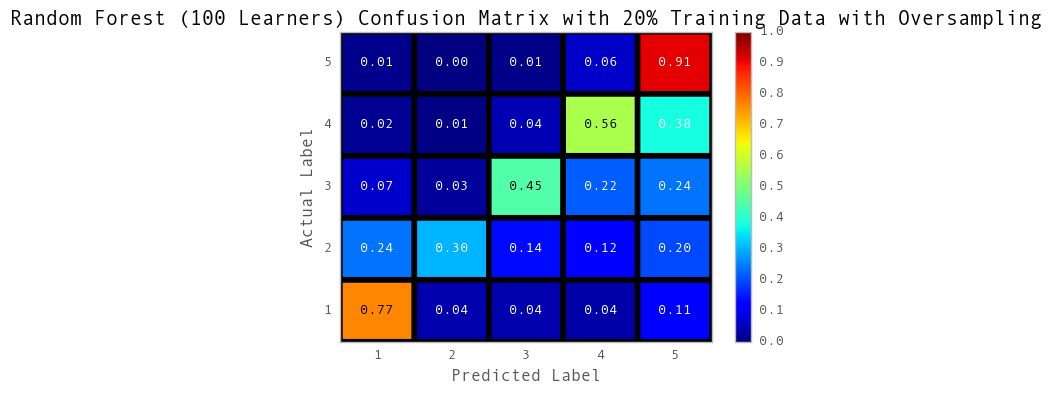

In [22]:
random_forest_confusion_matrix = confusion_matrix(test_y, forest100_pred)
plot_confusion_matrix(random_forest_confusion_matrix, 'Random Forest (100 Learners) Confusion Matrix with 20% Training Data with Oversampling',
                      savefilename='TwentyOversamplingRandomForestCM.png')

In [23]:
print_classifier_performance_metrics('Random Forest (100 Learners) with 20% Training Data', forest100_pred)

MODEL: Random Forest (100 Learners) with 20% Training Data

Precision: 0.7175643803
Recall: 0.72508315773
F1: 0.710133845734
Accuracy: 0.72508315773

Classification Report:
             precision    recall  f1-score   support

     1 star       0.63      0.77      0.69      3869
     2 star       0.63      0.30      0.41      2777
     3 star       0.62      0.45      0.52      5712
     4 star       0.72      0.56      0.63     16248
     5 star       0.76      0.91      0.83     28815

avg / total       0.72      0.73      0.71     57421


Precision variance: 0.014963

Recall variance: 0.238742
